In [ ]:
import os


os.environ['USER'] = 'SwatiMaste'
os.environ['REPO'] = 'AIH-Self-Learning-Tutorial'

# do everything in colab's "root" directory
%cd /content
!git clone https://github.com/${USER}/${REPO}.git

# make sure your repo shows up
%ls

/content
Cloning into 'AIH-Self-Learning-Tutorial'...
remote: Enumerating objects: 3354, done.
remote: Total 3354 (delta 0), reused 0 (delta 0), pack-reused 3354 (from 2)
Receiving objects: 100% (3354/3354), 130.55 MiB | 16.57 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (5882/5882), done.
AIH-Self-Learning-Tutorial/  sample_data/


In [ ]:
import numpy as np  # For numerical computations
import pandas as pd  # For dataframe operations
import random
import time
import urllib  # For fetching data from Web URLs

import cv2  # For image processing
from matplotlib import pyplot as plt  # For viewing images and plots

from sklearn.preprocessing import LabelEncoder  # For encoding categorical variables
from sklearn.model_selection import train_test_split  # For dataset splitting

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D,BatchNormalization,
    Activation, Dropout, Flatten, Dense, Add, AveragePooling2D, ReLU, Input
)
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG19, ResNet50, EfficientNetB0
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import keras
from keras import optimizers, layers, applications

# Ensure inline plots in Jupyter Notebook
%matplotlib inline


In [ ]:
# Setting up Pandas DataFrames for training dataset

filenames = os.listdir("/content/AIH-Self-Learning-Tutorial/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

<Axes: xlabel='category'>

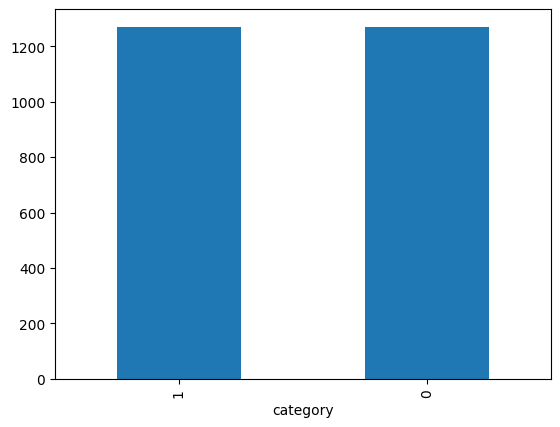

In [ ]:
# We see that its a evenly split dataset
train_df['category'].value_counts().plot.bar()

In [ ]:
# Setting up Pandas DataFrames for testing dataset

test_filenames = os.listdir("/content/AIH-Self-Learning-Tutorial/AutismDataset/test")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
test_df.head()

,filename,category
0,Autistic.42.jpg,1
1,Non_Autistic.527.jpg,0
2,Non_Autistic.607.jpg,0
3,Non_Autistic.261.jpg,0
4,Autistic.1056.jpg,1


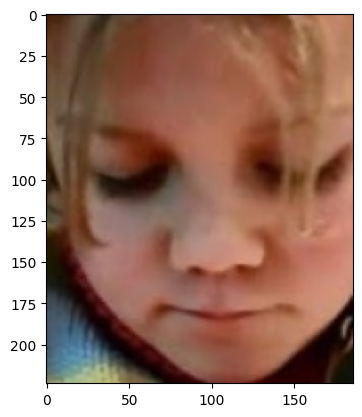

In [ ]:
# Sample Image from the dataset
sample = random.choice(filenames)
image = load_img("/content/AIH-Self-Learning-Tutorial/AutismDataset/train/"+sample)
plt.imshow(image)

In [ ]:
def improved_vgg19():
    # Input parameters
    image_size = 224
    input_shape = (image_size, image_size, 3)

    # Load pre-trained VGG19 with proper preprocessing
    pre_trained_model = VGG19(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling=None  # We'll add custom pooling later
    )

    # Freeze initial layers (transfer learning best practice)
    for layer in pre_trained_model.layers:
        layer.trainable = False

    # Unfreeze last convolutional block
    for layer in pre_trained_model.layers[-4:]:
        layer.trainable = True

    # Create new top layers
    x = pre_trained_model.output
    x = GlobalAveragePooling2D()(x)  # Better than GlobalMaxPooling for classification
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Compile model
    model = Model(pre_trained_model.input, outputs)

    # Use lower learning rate with Adam optimizer
    optimizer = Adam(learning_rate=1e-4)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# Create improved model
model = improved_vgg19()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,079,105 (80.41 MB)

 Trainable params: 8,132,097 (31.02 MB)

 Non-trainable params: 12,947,008 (49.39 MB)

In [ ]:
# Splitting the train dataset into train and validation sets (split - 90:10)
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()


total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print(total_train,total_validate)

2057 229


In [ ]:
# Training Data - Fetching the image data from the dataset using flow_from_dataframe

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/AIH-Self-Learning-Tutorial/AutismDataset/train",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2057 validated image filenames belonging to 2 classes.


In [ ]:
# Validation Data
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/AIH-Self-Learning-Tutorial/AutismDataset/train",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 229 validated image filenames belonging to 2 classes.


In [ ]:
# Model Training

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 52s 438ms/step - accuracy: 0.6459 - loss: 0.6500 - precision: 0.6653 - recall: 0.5653 - val_accuracy: 0.5091 - val_loss: 0.9412 - val_precision: 0.5091 - val_recall: 1.0000
Epoch 2/10
  1/102 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.7500 - loss: 0.5863 - precision: 0.6667 - recall: 0.7500

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7500 - loss: 0.5863 - precision: 0.6667 - recall: 0.7500 - val_accuracy: 0.4955 - val_loss: 1.0815 - val_precision: 0.4955 - val_recall: 1.0000
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.7076 - loss: 0.5862 - precision: 0.7067 - recall: 0.7042 - val_accuracy: 0.5045 - val_loss: 1.1654 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7500 - loss: 0.5926 - precision: 0.8750 - recall: 0.6364 - val_accuracy: 0.5045 - val_loss: 1.1909 - val_precision: 0.5045 - val_recall: 1.0000
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 402ms/step - accuracy: 0.7456 - loss: 0.5512 - precision: 0.7536 - recall: 0.7364 - val_accuracy: 0.6318 - val_loss: 0.8488 - val_precision: 0.5842 - val_recall: 0.9823
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6500 - loss: 0.4350 - precision: 0.6667 - recall: 0.7273 - val_accuracy: 0.6364 - val_loss: 0.85

In [ ]:
# Get all metrics
results = model.evaluate(validation_generator, steps=total_validate // batch_size)

# Print metrics using metric names
print("\nEvaluation Metrics:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# If you want specific access:
print(f"\nLoss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.7894 - loss: 0.5647 - precision: 0.7209 - recall: 0.9142

Evaluation Metrics:
loss: 0.5198
compile_metrics: 0.7727

Loss: 0.5198
Accuracy: 0.7727


In [ ]:
# Test Case
test_filenames = os.listdir("/content/AIH-Self-Learning-Tutorial/AutismDataset/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
# Testing Data
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/AIH-Self-Learning-Tutorial/AutismDataset/test",
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 300 validated image filenames.


In [ ]:
# Model Prediction

import numpy as np

threshold = 0.5
steps = int(np.ceil(nb_samples / batch_size))

predict = model.predict(test_generator, steps=steps)

# Flatten predictions for binary classification
test_df['category'] = np.where(predict.flatten() > threshold, 1, 0)

print(test_df.head())

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step
              filename  category
0      Autistic.42.jpg         1
1      Autistic.70.jpg         1
2  Non_Autistic.56.jpg         0
3      Autistic.71.jpg         1
4      Autistic.20.jpg         1


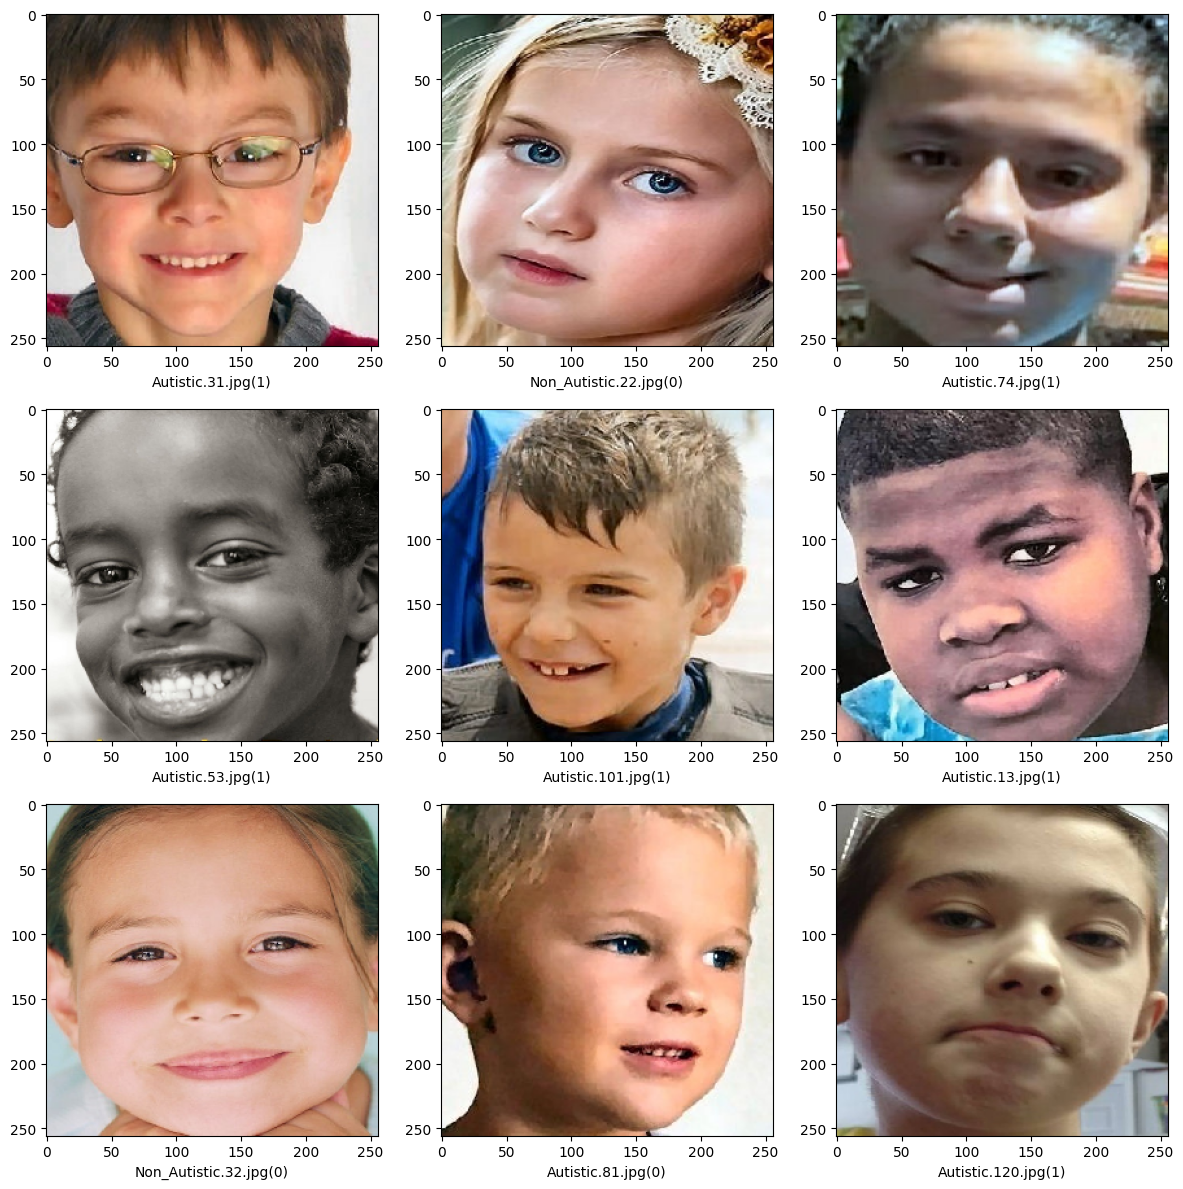

In [ ]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/AIH-Self-Learning-Tutorial/AutismDataset/test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()